In [2]:
# !pip install --index-url=https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com -r "requirements.txt"

Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/eb/09/b14d798bc02411b1e5a9896d680f8f417cadc53232bbf7ae9d30263dcf45/num2words-0.5.12-py3-none-any.whl (125 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/42/24/830571895f0927fe205a23309b136520c7914921420bd1e81aff1da47bb1/tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/de/44/bf1b0eef5b13e6201aef076ff34b91bc40aace8591cd273c1c2a94a9cc00/keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 1.1 MB/s eta 0:00:00ta 0:00:01
  Using cached bert_for_tf2-0.14.9-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:0

In [4]:
# pip install torch

In [5]:
import numpy as np
import pandas as pd
import warnings, os, sys, json, re, time, pickle, logging, collections
import multiprocessing as mp
import string
import nltk
import matplotlib.pyplot as plt

import multiprocessing
import time

from joblib import Parallel, delayed
from collections import Counter, defaultdict


from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet



set1 = set(list(STOPWORDS))
set2 = set(stopwords.words("english"))
filler_words = set(["uh","uhh","ohh","oh","ah","ahh","um","umm","umb","hmm","mhm",
                    "huh","er","err","ok","okay","hi","hello","please","may","thank",
                    "yes","today","no", "bye", "pii"])
stop_words = set1.union(set2).union(filler_words)
lemma = WordNetLemmatizer()
pattern = r'[^a-zA-Z0-9\s]'
only_nums = re.compile(r'[0-9]+\s|[0-9]+[^a-zA-Z0-9\s]')



with open("contractions_dict.json") as f:
    contractions_dict = json.load(f)



contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))



def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)



def preprocess_text(text):
   # expand contractions
    text = expand_contractions(text)
    # convert to lower case
    text = text.lower()
    text = nltk.word_tokenize(text)
    # remove stopwords
    text = " ".join(i for i in text if i not in stop_words)
    # lemmatize the text
    text = " ".join(lemma.lemmatize(word, pos="v") for word in text.split())
    # remove extra whitespaces
    text = re.sub(' +', ' ', text)
    # tokenize transcripts into sentences
    sentences_per_trans = [re.sub(pattern, ' ', sent) for sent in nltk.sent_tokenize(text, language='english')]
    # tokenize all sentences into words
    words_per_trans = [nltk.word_tokenize(sent) for sent in sentences_per_trans]
    return [word for sent_tokens in words_per_trans for word in sent_tokens if word.isalpha()]

In [6]:
# function to prepare n-grams
def count_ngrams(lines, min_length=1, max_length=3):
    lengths = range(min_length, max_length+1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen = max_length)
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current)>= length:
                ngrams[length][current[:length]] +=1
    for line in lines:
        for word in nltk.word_tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()
    while len(queue) > min_length:
        queue.popleft()
        add_queue()
    return ngrams

In [40]:
def Runner(df,return_dict):
    WordCloud_df = pd.DataFrame()
    for group, frame in df.groupby(["client_id", "segment_start_time", "primary_predicted",
                                        "secondary_predicted","tertiary_predicted","root_cause_predicted"]):
        frame["transcripts"] = frame["transcripts"].apply(lambda text: preprocess_text(text))
        frame["transcripts"] = frame["transcripts"].apply(lambda x: " ".join(x))
        frame.segment_start_time = pd.to_datetime(frame.segment_start_time).dt.date

        ngram_dict = count_ngrams(frame.transcripts)
        ngram_df = (
            pd.concat([pd.DataFrame.from_dict(ngram_dict[1].items()).assign(Type="Unigram"), 
                       pd.DataFrame.from_dict(ngram_dict[2].items()).assign(Type="Bigram"),
                       pd.DataFrame.from_dict(ngram_dict[3].items()).assign(Type="Trigram")])
            .rename(columns={0:"Words/Tokens", 1:"Count"})
        )

        ngram_df = ngram_df.assign(Client_Id=group[0], Date=group[1], Primary_Driver=group[2], 
                                   Secondary_Driver=group[3], Tertiary_Driver=group[4], Root_Cause=group[5])
        WordCloud_df = pd.concat([WordCloud_df, ngram_df])
    WordCloud_df = WordCloud_df[WordCloud_df.columns[5:].tolist() + WordCloud_df.columns[:5].tolist()]
    # tmstmp = str(time.time()).replace(".","_")
    # return_dict[f"df_{tmstmp}"] = WordCloud_df.copy()
    return_dict.put_nowait(WordCloud_df)

In [48]:
%%time
df = pd.read_parquet("Final_Preds.parquet")
df.columns = [col.lower() for col in df.columns]

CPU times: user 825 ms, sys: 611 ms, total: 1.44 s
Wall time: 1.11 s


In [49]:
df.shape

(43490, 26)

In [50]:
df.shape

(43490, 26)

In [51]:
df[['primary_predicted', 'secondary_predicted', 'tertiary_predicted']] = df['prediction'].str.split('_',expand=True)

 

# df.rename(columns={"root_cause_predicted":"root_cause"}, inplace=True)

 

#reading the data file- need to comment this once the data is fed using the function parameter
#data = pd.read_parquet(path='s3://adl-core-sagemaker-studio/external/Yashasvi/TranscriptOnly_Intent_Classification/Monthly_prediction/predicted_result_2022-10-11_15:27:34.parquet.gzip')

 

#renaming the datetime columns to the ons which was sent earlier
df.rename(columns={"starttime":"segment_start_time","endtime":"segment_end_time"},inplace=True)

 

#pickingnonly required columns for final display purpose
df = df[['client_id', 'client_name', 'universal_id', 'segment_start_time', 'segment_end_time',
         'root_cause_predicted', 'primary_predicted', 'secondary_predicted', 'tertiary_predicted','transcripts','recordingid','sub_bucket','conversationid']]

 

#converting date time to desired format as required for display purpose
df['segment_start_time'] = pd.to_datetime(df['segment_start_time'])
df['segment_end_time'] = pd.to_datetime(df['segment_end_time'])

 

df['segment_start_time'] = df['segment_start_time'].dt.strftime('%Y-%m-%d %H:%M')
df['segment_end_time'] = df['segment_end_time'].dt.strftime('%Y-%m-%d %H:%M')

 

#dropping duplicates
df = df.drop_duplicates().reset_index(drop=True)




In [52]:
# df = df.sample(n=5000)


In [53]:
%%time


manager = multiprocessing.Manager()
return_dict = manager.Queue()

processes = []

NB_BATCHES = 25
len_batch = len(df)//NB_BATCHES

for j in range(NB_BATCHES+1):
    temp_df = df.copy().iloc[j*len_batch:(j+1)*len_batch]
    p = multiprocessing.Process(target=Runner, args=(temp_df, return_dict))
    processes.append(p)
    p.start()

for i in processes:
    i.join()

CPU times: user 756 ms, sys: 7.17 s, total: 7.93 s
Wall time: 5min 29s


In [56]:
WordCloud_df = []
while not return_dict.empty():
    WordCloud_df.append(return_dict.get())

WordCloud_df = pd.concat(WordCloud_df, ignore_index=True)

In [57]:
# collect_df = return_dict.values()

In [58]:
%%time
# WordCloud_df = pd.concat(collect_df)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [59]:
WordCloud_df.head()

,Primary_Driver,Secondary_Driver,Tertiary_Driver,Root_Cause,Words/Tokens,Count,Type,Client_Id,Date
0,Cross Solution,Access,Proxy/Delegate access,Education,"(patience,)",1,Unigram,1012,2023-06-13 18:22
1,Cross Solution,Access,Proxy/Delegate access,Education,"(cigna,)",2,Unigram,1012,2023-06-13 18:22
2,Cross Solution,Access,Proxy/Delegate access,Education,"(employee,)",1,Unigram,1012,2023-06-13 18:22
3,Cross Solution,Access,Proxy/Delegate access,Education,"(service,)",1,Unigram,1012,2023-06-13 18:22
4,Cross Solution,Access,Proxy/Delegate access,Education,"(center,)",1,Unigram,1012,2023-06-13 18:22


In [60]:
WordCloud_df.shape

(30610437, 9)

In [61]:
grouped_sum = WordCloud_df.groupby(['Primary_Driver', 'Type','Client_Id'], as_index=False)[["Count"]].sum().rename(columns={"Count":"Overall_Count_By_Type"})


In [62]:
# grouped_sum

In [63]:
WordCloud_df = WordCloud_df.merge(grouped_sum, how="left",on=['Primary_Driver', 'Type','Client_Id'], copy=False)
WordCloud_df = WordCloud_df.assign(Normalized_Count=WordCloud_df.Count/WordCloud_df.Overall_Count_By_Type)

In [64]:
# WordCloud_df.head(2)

In [65]:
groupby_list = [col for col in WordCloud_df.columns if col != "Count"]
print(groupby_list)

['Primary_Driver', 'Secondary_Driver', 'Tertiary_Driver', 'Root_Cause', 'Words/Tokens', 'Type', 'Client_Id', 'Date', 'Overall_Count_By_Type', 'Normalized_Count']


In [66]:
Wc_updated_df = WordCloud_df.groupby(groupby_list, as_index=False)["Count"].sum()

In [67]:
# Wc_updated_df.to_parquet("s3://adl-core-dev-sagemaker-studio/external/Kartik/WordCloud_Data_Sep22_With_Bigrams_Trigrams.parquet", index=False)

In [68]:
groupby_list.remove('Date')

In [25]:
writer_obj = pd.ExcelWriter('WordCloud_Data_Sample_for_Analysis.xlsx')

In [26]:
(
    Wc_updated_df.query('Primary_Driver == "Cross Solution" & Secondary_Driver == "Leaves" & Tertiary_Driver == "Leaves Pay" \
                    & Type == "Unigram" & Root_Cause == "Education" & Client_Id == 1012')
    .groupby(groupby_list, as_index=False)["Count"].sum().sort_values(by="Count", ascending=False)
    .to_excel(writer_obj,sheet_name='Unigram',startrow=2,index=False)
)

(
    Wc_updated_df.query('Primary_Driver == "Cross Solution" & Secondary_Driver == "Leaves" & Tertiary_Driver == "Leaves Pay" \
                    & Type == "Bigram" & Root_Cause == "Education" & Client_Id == 1012')
    .groupby(groupby_list, as_index=False)["Count"].sum().sort_values(by="Count", ascending=False)
    .to_excel(writer_obj,sheet_name='Bigram',startrow=2,index=False)
)

(
    Wc_updated_df.query('Primary_Driver == "Cross Solution" & Secondary_Driver == "Leaves" & Tertiary_Driver == "Leaves Pay" \
                    & Type == "Trigram" & Root_Cause == "Education" & Client_Id == 1012')
    .groupby(groupby_list, as_index=False)["Count"].sum().sort_values(by="Count", ascending=False)
    .to_excel(writer_obj,sheet_name='Trigram',startrow=2,index=False)
)

writer_obj.save()
writer_obj.close()

In [27]:
# Wc_updated_df.query('Type == "Trigram" & Root_Cause == "Education" & Client_Id == 1012').sort_values(by="Count", ascending=False).head(10)

=====================Ends Here ================================

In [31]:
Wc_updated_df.shape

(18032116, 11)

In [32]:
Wc_updated_df['Words/Tokens'] = Wc_updated_df['Words/Tokens'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)


In [33]:
ngrams = Wc_updated_df['Words/Tokens'].tolist()

In [34]:
df_kw =pd.read_csv("s3://adl-core-dev-sagemaker-studio/external/Kartik/keywords.csv")

df_kw["Keywords"]= df_kw["Keywords"].str.split(" ")


df_kw["Keywords"] = [','.join(map(str, l)) for l in df_kw["Keywords"]]

df_kw["Keywords"]  = df_kw["Keywords"].str.replace(',', ' ')

kw_arg = df_kw["Keywords"].tolist()

In [37]:
# pip install sentence_transformers

In [38]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

In [39]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [40]:
embedded_list_ngrams = model.encode(ngrams)

In [41]:
embedded_list_ngrams.shape

(18032116, 384)

In [42]:
embedded_list_kw = model.encode(kw_arg)

In [43]:
embedded_list_kw.shape

(177, 384)

cosine Similarities

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [45]:
cosiinnn = cosine_similarity(embedded_list_ngrams,embedded_list_kw)

In [46]:
cosiinnn.shape

(18032116, 177)

In [48]:
max_indices = np.argmax(cosiinnn, axis=1)
max_scores = np.max(cosiinnn, axis=1)

In [49]:
kw_series = df_kw.iloc[max_indices,:].Keywords.tolist()

In [50]:
Wc_updated_df = Wc_updated_df.assign(max_score=max_scores, keyword=kw_series)

In [44]:
# Wc_updated_df[Wc_updated_df.max_score > Wc_updated_df.max_score.quantile(0.75)]

In [ ]:
# Wc_updated_df['Words/Tokens']

In [ ]:
#############Grouping client-id, ngrams,primary drivers #############

In [ ]:
# Wc_updated_df.shape

In [51]:
Wc_updated_df['Words/Tokens'] = Wc_updated_df['Words/Tokens'].str.replace(',', ' ')
# Wc_updated_df['Words/Tokens']  = Wc_updated_df['Words/Tokens'].str.replace(' ', '_')

In [6]:
df2 = pd.read_parquet("s3://adl-core-dev-sagemaker-studio/external/Kartik/Bigrams_Trigrams0823.parquet")

In [7]:
df2.head(5)

,Primary_Driver,Secondary_Driver,Tertiary_Driver,Root_Cause,Words/Tokens,Type,Client_Id,Date,Overall_Count_By_Type,Normalized_Count,Count,max_score,keyword
0,401k,Contributions,Contribution Change,Education,able,Unigram,1881,2022-08-03 17:21,12453.0,0.000080,1.0,0.465185,course
1,401k,Contributions,Contribution Change,Education,able assist,Bigram,1881,2022-08-03 17:21,12407.0,0.000081,1.0,0.343863,request feedback
2,401k,Contributions,Contribution Change,Education,account,Unigram,1881,2022-08-03 17:21,12453.0,0.000080,1.0,0.651683,account balance
3,401k,Contributions,Contribution Change,Education,account get,Bigram,1881,2022-08-03 17:21,12407.0,0.000081,1.0,0.507701,account balance
4,401k,Contributions,Contribution Change,Education,account get error,Trigram,1881,2022-08-03 17:21,12361.0,0.000081,1.0,0.470523,account balance


In [ ]:
df2.describe()

In [8]:
df2.shape

(18032116, 13)

In [75]:
df3 = df2.loc[df2['Type'].isin(['Bigram','Trigram'])]

In [76]:
df3.shape

(14666594, 13)

In [76]:
df3.shape

(14666594, 13)

In [77]:
def final_threshold(value):
    rslt_df = df3[(df3['max_score'] >=int(value))].sort_values(by="Normalized_Count", ascending=False)
    final_dict = dict(zip(rslt_df['Words/Tokens'], rslt_df['Normalized_Count']))
    return final_dict

In [78]:
# pip install WordCloud

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [80]:
def plot_wordcloud(thresh):
    wordcloud = WordCloud(width =1000, height=900)
    wordcloud.generate_from_frequencies(frequencies= final_threshold(thresh))
    plt.figure(figsize=(10,9))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

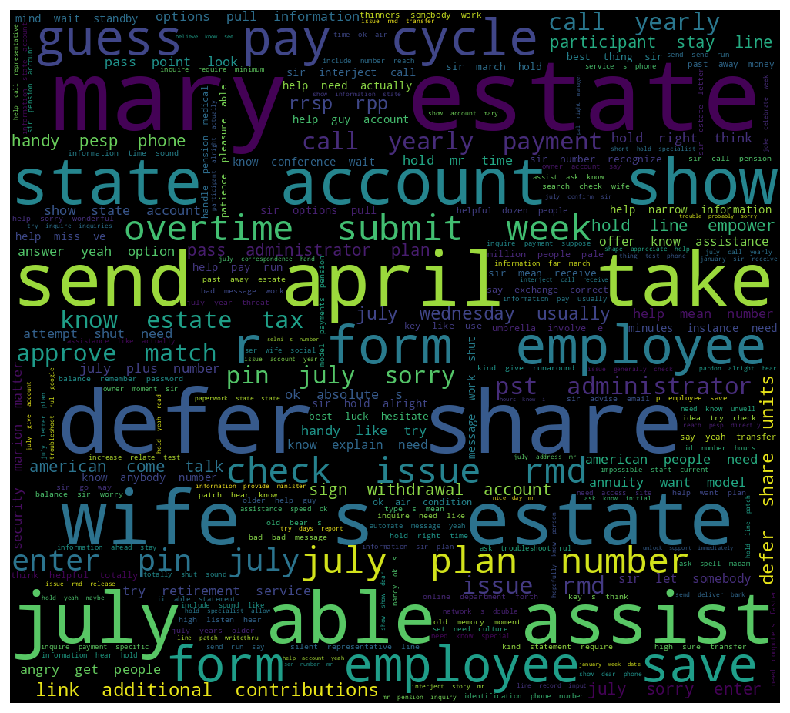

In [87]:
plot_wordcloud(0.2)

In [83]:
# plot_wordcloud(0.6)

In [84]:
# plot_wordcloud(0.7)

In [85]:
# plot_wordcloud(0.8)

In [86]:
# plot_wordcloud(0.9)

In [74]:
# Wc_updated_df=Wc_updated_df[(Wc_updated_df['max_score'] <=0.5)]

In [75]:
Wc_updated_df.shape

(1, 13)

In [53]:
Wc_updated_df.to_parquet("s3://adl-core-dev-sagemaker-studio/external/Kartik/Bigrams_Trigrams0823.parquet", index=False)

In [62]:
# Wc_updated_df.to_excel("Similarity_value_Wordcloud_full_volume_data.xlsx", index=False)

In [54]:
df2 = pd.read_parquet("s3://adl-core-dev-sagemaker-studio/external/Kartik/Bigrams_Trigrams0823.parquet")

In [56]:
df2.shape

(18032116, 13)

In [59]:
df2.head(5)

,Primary_Driver,Secondary_Driver,Tertiary_Driver,Root_Cause,Words/Tokens,Type,Client_Id,Date,Overall_Count_By_Type,Normalized_Count,Count,max_score,keyword
0,401k,Contributions,Contribution Change,Education,able,Unigram,1881,2022-08-03 17:21,12453.0,0.000080,1.0,0.465185,course
1,401k,Contributions,Contribution Change,Education,able assist,Bigram,1881,2022-08-03 17:21,12407.0,0.000081,1.0,0.343863,request feedback
2,401k,Contributions,Contribution Change,Education,account,Unigram,1881,2022-08-03 17:21,12453.0,0.000080,1.0,0.651683,account balance
3,401k,Contributions,Contribution Change,Education,account get,Bigram,1881,2022-08-03 17:21,12407.0,0.000081,1.0,0.507701,account balance
4,401k,Contributions,Contribution Change,Education,account get error,Trigram,1881,2022-08-03 17:21,12361.0,0.000081,1.0,0.470523,account balance


In [69]:
Wc_updated_df.to_csv("s3://adl-core-dev-sagemaker-studio/external/Kartik/WordCloud_Data_Sep22_With_Bigrams_Trigrams.csv", index=False)